In [103]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import libraries
import os
import numpy as np
import subprocess
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import fixed, interact_manual
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths, peak_prominences
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Arial']
rcParams['svg.fonttype'] = 'none'

# Local module and scripts
from pyccapt.calibration.calibration import widgets as wd
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.tutorials.tutorials_helpers import helper_calibration
from pyccapt.calibration.tutorials.tutorials_helpers import helper_data_loader
from pyccapt.calibration.tutorials.tutorials_helpers import helper_temporal_crop
from pyccapt.calibration.tutorials.tutorials_helpers import helper_special_crop
from pyccapt.calibration.tutorials.tutorials_helpers import helper_t_0_tune
from pyccapt.calibration.tutorials.tutorials_helpers import helper_mc_plot
from pyccapt.calibration.tutorials.tutorials_helpers import helper_3d_reconstruction
from pyccapt.calibration.tutorials.tutorials_helpers import helper_ion_selection
from pyccapt.calibration.tutorials.tutorials_helpers import helper_visualization
from pyccapt.calibration.tutorials.tutorials_helpers import helper_ion_list
from pyccapt.calibration.calibration import share_variables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# create an object for selection of instrument specifications of the dataset
tdc, pulse_mode, flight_path_length, t0, max_mc, det_diam = wd.dataset_instrument_specification_selection()

# Display lists and comboboxes to selected instrument specifications
display(tdc, pulse_mode, flight_path_length, t0, max_mc)

Dropdown(description='Data mode:', options=('pyccapt', 'leap_epos', 'leap_pos', 'leap_apt', 'ato_v6'), value='…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=38.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

In [104]:
# create an instance of the Variables opject
variables = share_variables.Variables()
variables.pulse_mode = pulse_mode

In [111]:
# dataset_path =  'D:/pyccapt/tests/data/physics_experiment/data_204_Feb-01-2024_11-51_Constant_power_W/data_processing/data_204_Feb-01-2024_11-51_Constant_power_W.h5'
# dataset_path_12fs =  'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
# variables.result_data_name = '12fs'

# dataset_path = 'D:/pyccapt/tests/data/physics_experiment/R56_07910-v04/R56_07910-v01/visualization/R56_07910-v01.h5'
# dataset_path_12ps = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/LEAP_R56_09319_W_RT_powersweep/R56_09319-v01.h5'
# variables.result_data_name = '12ps'

dataset_path =  'D:/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
variables.result_data_name = '12fs_power_sweep'

# dataset_path = 'D:/pyccapt/tests/data/physics_experiment/LEAP_R56_09319_W_RT_powersweep/R56_09319-v01.h5'
# variables.result_data_name = '12ps_power_sweep'


In [112]:
# exctract needed data from Pandas data frame as an numpy array


# variables.result_data_path = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/results/MRP/' + variables.result_data_name + '/'
# variables.result_path ='C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/results/MRP/' + variables.result_data_name + '/'

variables.result_data_path = 'D:/pyccapt/tests/data/physics_experiment/results/MRP/' + variables.result_data_name + '/'
variables.result_path ='D:/pyccapt/tests/data/physics_experiment/results/MRP/' + variables.result_data_name + '/'

if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
# Create data farame out of hdf5 file dataset
variables.data = data_tools.load_data(dataset_path, tdc.value, mode='processed')

data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
display(variables.data)

The maximum possible time of flight is: 18220


,x (nm),y (nm),z (nm),mc (Da),mc_uc (Da),high_voltage (V),pulse,t (ns),t_c (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp,start_counter
0,0.0,0.0,0.0,31.055637,32.711614,7502.297363,4338.635254,1209.0334,1290.271166,2.596390,-0.944264,0,1,24473
1,0.0,0.0,0.0,285.346074,300.865685,7502.297363,4338.635254,3613.1879,3839.640636,0.418139,-2.817090,2,1,24475
2,0.0,0.0,0.0,85.952736,89.929871,7502.297363,4338.635254,1989.6626,2123.397187,-1.650750,2.580620,1,1,24476
3,0.0,0.0,0.0,283.479624,298.633544,7502.297363,4338.635254,3586.8682,3827.180011,-0.741346,-1.753150,1,1,24477
4,0.0,0.0,0.0,45.028272,47.602763,7502.297363,4338.635254,1458.1421,1546.579332,-3.487050,0.084248,1,1,24478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715635,0.0,0.0,0.0,101.007077,105.440931,6096.536133,10792.778320,2377.6851,2298.880112,0.264085,2.394260,2,1,1143238
715636,0.0,0.0,0.0,92.013962,96.185879,6096.536133,10792.778320,2268.7300,2195.766479,0.295543,1.959480,1,1,1143239
715637,0.0,0.0,0.0,218.204749,228.091370,6096.536133,10792.778320,3478.6579,3362.157518,-1.251890,1.485290,1,1,1143240
715638,0.0,0.0,0.0,91.518834,96.312066,6096.536133,10792.778320,2266.8570,2189.946021,0.899990,-1.134980,1,1,1143241


In [113]:
import matplotlib as mpl

# Set agg.path.chunksize to prevent OverflowError
mpl.rcParams['agg.path.chunksize'] = 10000  # You can increase this if necessary

In [114]:
left_bound = 91.7
right_bound = 92.3

In [115]:
mask = (variables.mc < right_bound) & (variables.mc > left_bound)
aa = variables.mc[mask]

Number of found peaks: 2
MRP 0.5: MRP: ***942.1738*** Peak Location: 91.9675, Peak Height: 1.0000, Left Bound: 91.9304, Left Height: 0.4754, Right Bound: 92.0280, Right Height: 0.4930
Number of found peaks: 2
MRP 0.1: MRP: ***403.7888*** Peak Location: 91.9675, Peak Height: 1.0000, Left Bound: 91.8803, Left Height: 0.1080, Right Bound: 92.1080, Right Height: 0.1056
Number of found peaks: 2
MRP 0.01: MRP: ***243.6656*** Peak Location: 91.9675, Peak Height: 1.0000, Left Bound: 91.8308, Left Height: 0.0164, Right Bound: 92.2082, Right Height: 0.0176
Number of found peaks: 2
MRP 0.5: MRP: ***841.3337*** Peak Location: 91.9792, Peak Height: 0.9335, Left Bound: 91.9232, Left Height: 0.4729, Right Bound: 92.0325, Right Height: 0.4782
Number of found peaks: 2
MRP 0.1: MRP: ***372.9395*** Peak Location: 91.9792, Peak Height: 0.9335, Left Bound: 91.8738, Left Height: 0.1079, Right Bound: 92.1204, Right Height: 0.1084
Number of found peaks: 2
MRP 0.01: MRP: ***219.8197*** Peak Location: 91.9792, 

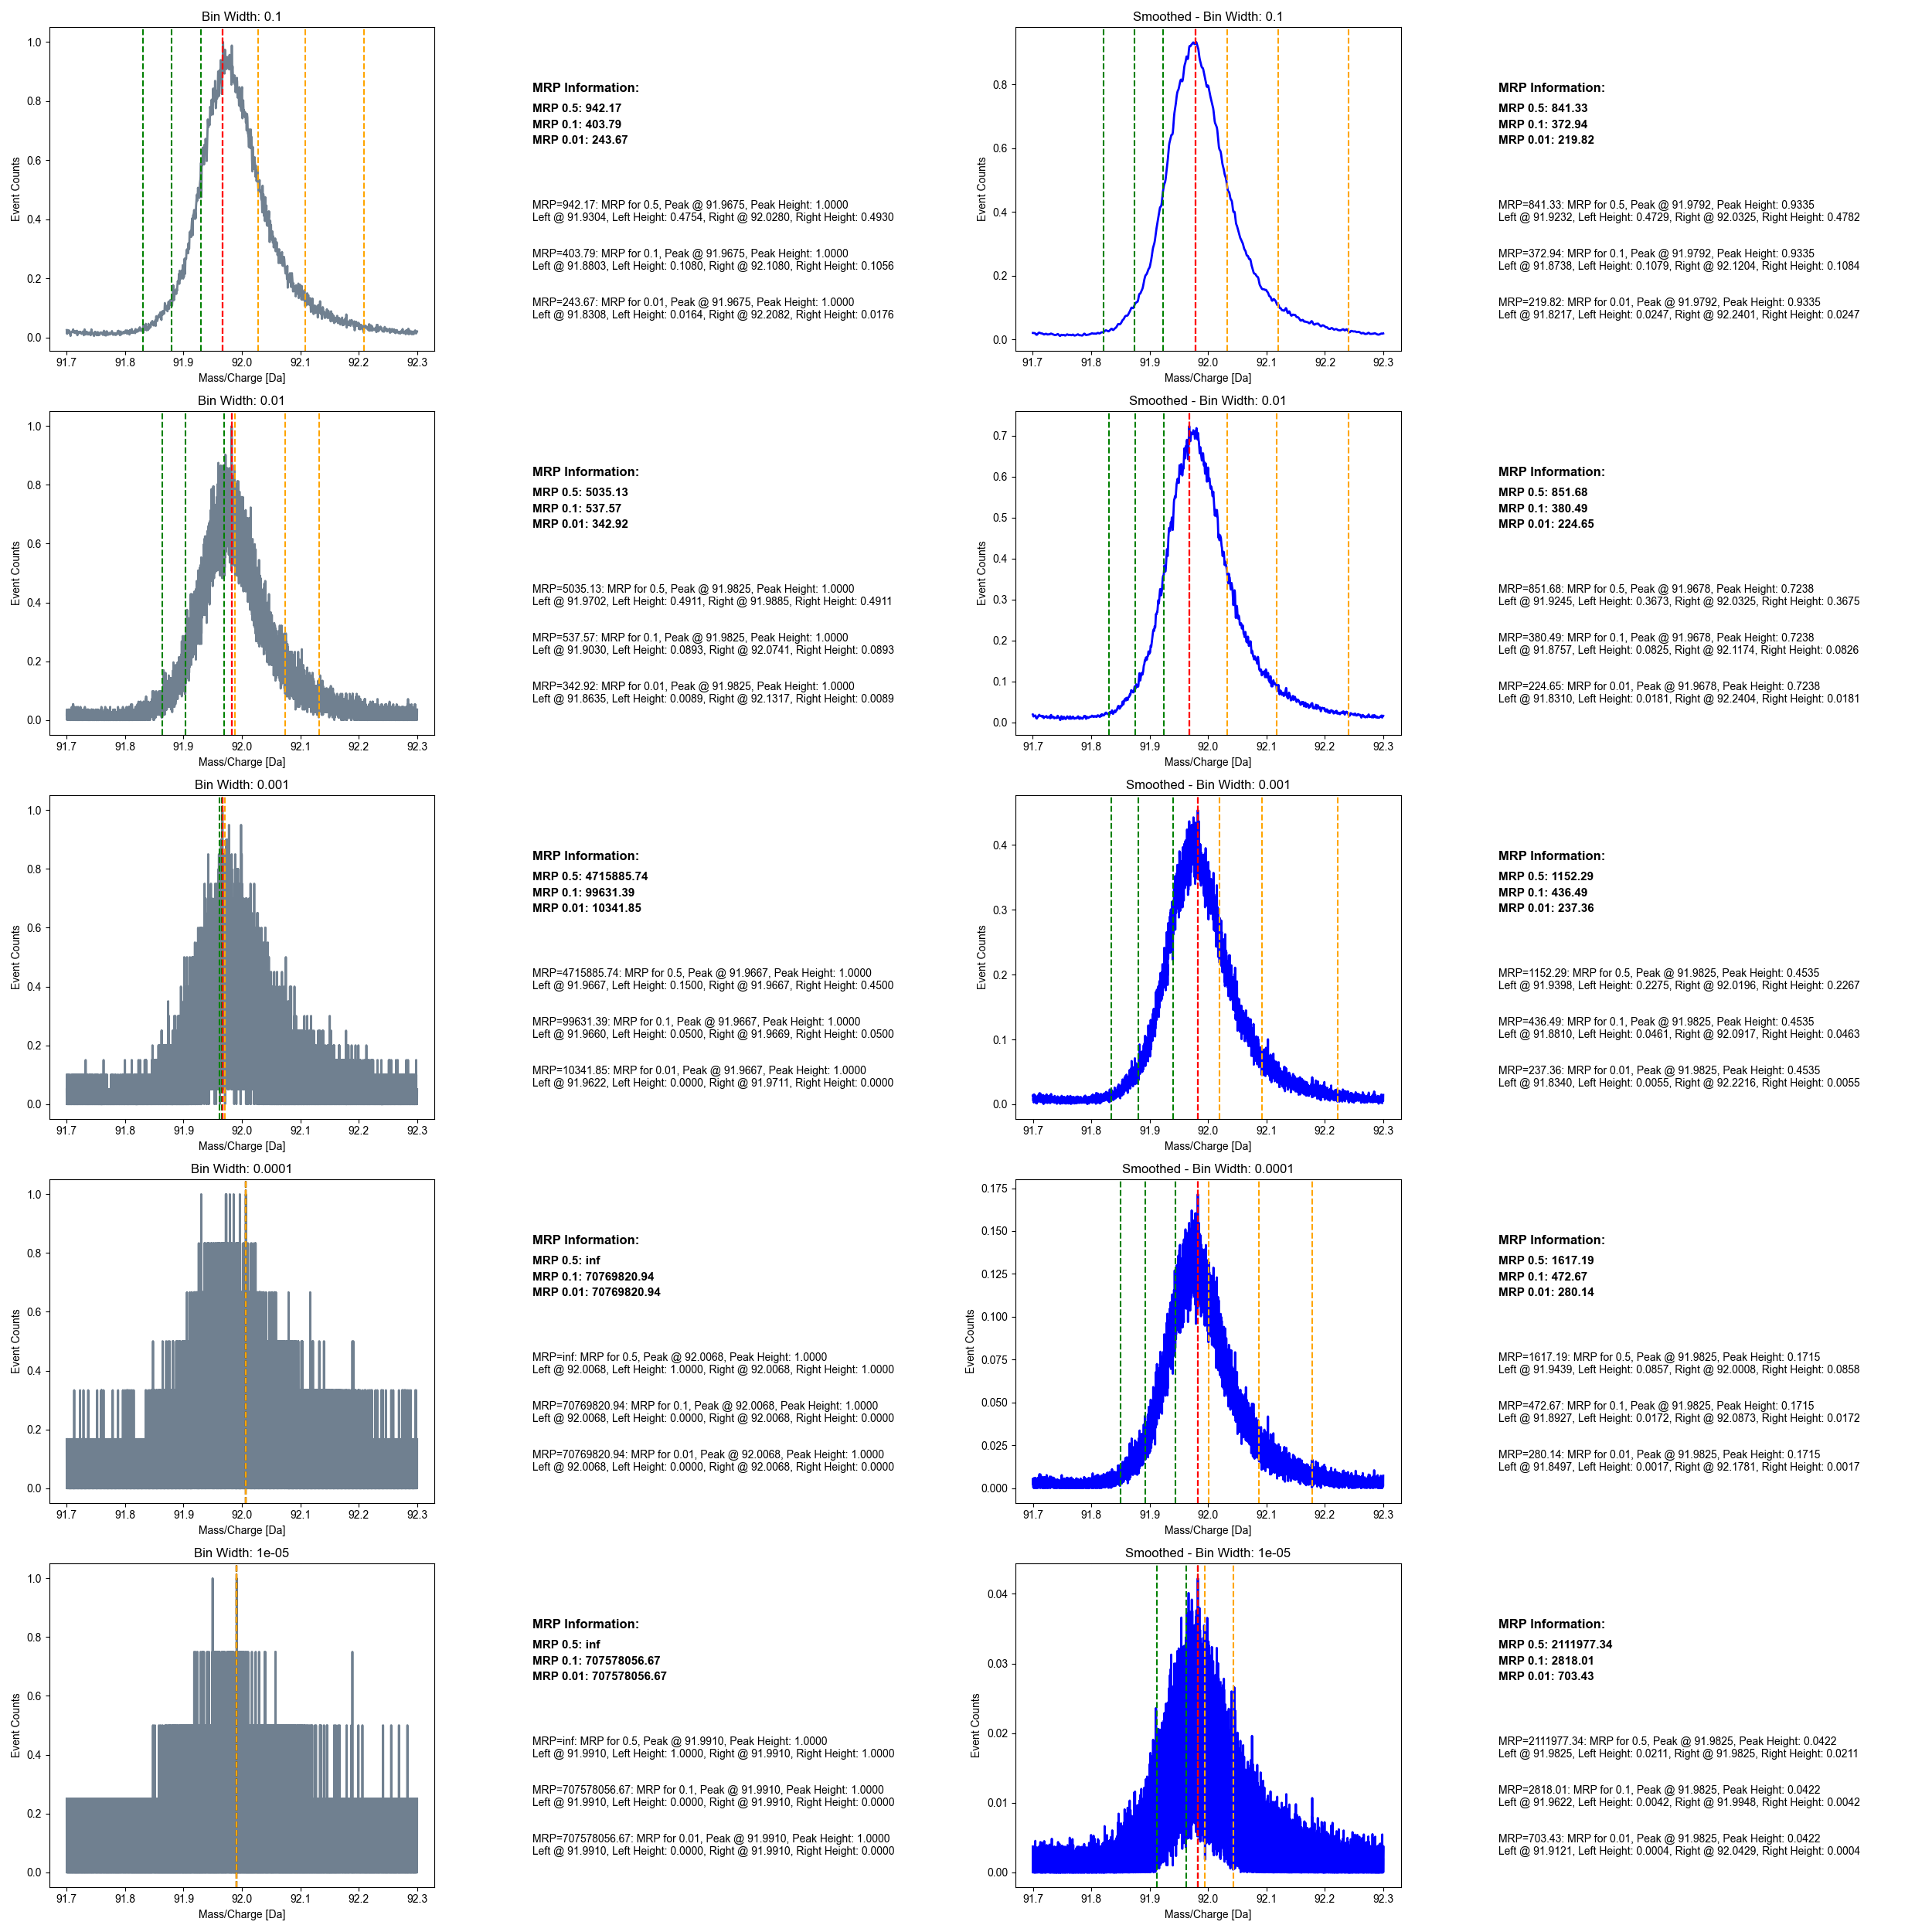

In [118]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, peak_prominences

# Assuming 'aa' is your input data array and 'variables.result_path' & 'variables.result_data_name' are defined somewhere else in your script

# Define the MRP range and bin size list
mrp_range = [0.5, 0.1, 0.01]  # You can adjust this as necessary
bin_size_list = [0.1, 0.01, 0.001, 0.0001, 0.00001]  # List of bin sizes
sigma_list = [2, 8, 12, 54, 54]  # Smoothing levels for each bin size

# Create a larger figure with 5 rows and 4 columns
fig, axes = plt.subplots(len(bin_size_list), 4, figsize=(25, 25), constrained_layout=True)  # 5 rows, 4 columns

# Loop through each bin size in the bin size list
for index, bin_width in enumerate(bin_size_list):
    bins = np.linspace(np.min(aa), np.max(aa), round(np.max(aa) / bin_width))
    hist, bin_edges = np.histogram(aa, bins=bins)
    hist = hist / np.max(hist)  # Normalize histogram
    
    # Get bin centers for line plot
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Apply Gaussian filter for smoothing
    hist_smooth = gaussian_filter1d(hist, sigma=sigma_list[index]) 

    # Plot the histogram using a line plot
    ax_hist = axes[index, 0]
    ax_hist.plot(bin_centers, hist, color='slategray', linewidth=2, label='Original Histogram')
    ax_hist.set_title(f'Bin Width: {bin_width}')
    ax_hist.set_xlabel('Mass/Charge [Da]')
    ax_hist.set_ylabel('Event Counts')

    # Plot the smoothed histogram using a line plot
    ax_hist_smooth = axes[index, 2]
    ax_hist_smooth.plot(bin_centers, hist_smooth, color='blue', linewidth=2, label='Smoothed Histogram')
    ax_hist_smooth.set_title(f'Smoothed - Bin Width: {bin_width}')
    ax_hist_smooth.set_xlabel('Mass/Charge [Da]')
    ax_hist_smooth.set_ylabel('Event Counts')

    mrp_data_dict = {}
    # Function to perform peak analysis and MRP calculation for both histograms
    def analyze_peaks(hist_data, ax_idx):
        bound_lines = []
        bound_labels = []
    
        for mrp_s in mrp_range:
            mrp_r = 1 - mrp_s
    
            # Step 1: Find the peaks in the histogram
            peaks, properties = find_peaks(hist_data, prominence=int(np.max(hist_data) * 0.8), distance=int(len(bins) / 2), height=0)
            print('Number of found peaks:', len(peaks))
    
            # Step 2: Calculate peak widths
            peak_width = peak_widths(hist_data, peaks, rel_height=mrp_r, prominence_data=None)
    
            # Step 3: Calculate peak prominences
            prominences = peak_prominences(hist_data, peaks, wlen=None)
    
            # Step 4: Find the index of the peak with the maximum prominence
            if len(prominences[0]) > 0:
                index_peak_max = np.argmax(prominences[0])
    
                # Step 5: Calculate the MRP
                mrp_tmp = bin_edges[peaks][index_peak_max] / (bin_edges[round(peak_width[3][index_peak_max])] - 
                                                              bin_edges[round(peak_width[2][index_peak_max])])

                # Add MRP information to the dictionary
                mrp_data_dict[mrp_s] = {
                    'MRP': mrp_tmp,
                }
    
                # Step 6: Print the peak location and its left and right bounds
                peak_loc = bin_edges[peaks][index_peak_max]
                left_bound = bin_edges[round(peak_width[2][index_peak_max])]
                right_bound = bin_edges[round(peak_width[3][index_peak_max])]
    
                # Calculate the heights at the peak, left bound, and right bound
                peak_height = hist_data[peaks][index_peak_max]
                left_height = hist_data[round(peak_width[2][index_peak_max])]
                right_height = hist_data[round(peak_width[3][index_peak_max])]
    
                print(f"MRP {mrp_s}: MRP: ***{mrp_tmp:.4f}*** Peak Location: {peak_loc:.4f}, Peak Height: {peak_height:.4f}, "
                      f"Left Bound: {left_bound:.4f}, Left Height: {left_height:.4f}, Right Bound: {right_bound:.4f}, Right Height: {right_height:.4f}")
    
                # Highlight the peak location, left, and right bounds on the plot
                peak_line = axes[index, ax_idx].axvline(x=peak_loc, color='red', linestyle='--')
                left_line = axes[index, ax_idx].axvline(x=left_bound, color='green', linestyle='--')
                right_line = axes[index, ax_idx].axvline(x=right_bound, color='orange', linestyle='--')
    
                # Add a single combined legend for MRP, peak, left, and right bounds for text
                bound_lines.extend([left_line, right_line])
                bound_labels.append(
                    f'MRP={mrp_tmp:.2f}: MRP for {mrp_s}, Peak @ {peak_loc:.4f}, Peak Height: {peak_height:.4f}\n'
                    f'Left @ {left_bound:.4f}, Left Height: {left_height:.4f}, Right @ {right_bound:.4f}, Right Height: {right_height:.4f}'
                )
    
            else:
                print(f"MRP {mrp_s}: No peaks found for bin width {bin_width}")
        

        # Plot the MRP information on the corresponding subplot
        ax_mrp_info = axes[index, ax_idx + 1]
        ax_mrp_info.axis('off')  # Turn off the axis
        ax_mrp_info.text(0.001, 0.8, 'MRP Information:', fontsize=12, fontweight='bold')
        q = 0
        for mrp_s, data in mrp_data_dict.items():
            ax_mrp_info.text(0.001, 0.7 - q * 0.05, f'MRP {mrp_s}: {data["MRP"]:.2f}\n', fontsize=11, fontweight='bold')
            q += 1
        q = 0
    
        # Create a text box for each MRP and bounds
        for i, label in enumerate(bound_labels):
            ax_mrp_info.text(0.001, 0.4 - i * 0.15, label, fontsize=10)  # Adjust the y-position for better spacing

    # Analyze peaks for the original histogram (column 1 and 2)
    analyze_peaks(hist, ax_idx=0)

    # Analyze peaks for the smoothed histogram (column 3 and 4)
    analyze_peaks(hist_smooth, ax_idx=2)

# Adjust the layout and display the full figure
plt.tight_layout()
plt.show()

# Optionally, you can save the figure as a single large image file
plt.savefig(variables.result_path + "/" + variables.result_data_name + "_combined_MRP.png", format="png", dpi=600)
plt.savefig(variables.result_path + "/" + variables.result_data_name + "_combined_MRP.svg", format="svg", dpi=600)
